In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.0f}'.format


### reorden_20250115.csv:
Contiene la política de reorden para cada producto en cada tienda:
- id_tienda: tienda física
- id_producto: producto
- reorden: cantidad mínima de inventario para reabastecer (valor Q)
- frecuencia_reorden: cada cuántos días se evalúa el reabastecimiento (en días)

### venta_tienda_1_20250115.csv
Ventas físicas del día 1:
- id_tienda, id_producto
- venta_tienda: unidades vendidas físicamente

### venta_zona_1_20250115.csv
Ventas digitales del día 1:
- id_zona: zona (probablemente asociada a tienda)
- id_producto, venta_digital: ventas en línea

### tiendas_20250115.csv
Contiene la ubicación y tipo de tienda:
- id_tienda, tipo_tienda, coordenadas pos_x, pos_y

### zonas_20250115.csv
Indica a qué tienda pertenece cada zona digital:
- id_zona, coordenadas x_zona, y_zona
- tienda_zona: mapeo zona digital → tienda física

Esto permite asignar las ventas digitales a las tiendas correspondientes, lo cual es esencial para consolidar la demanda y decidir los reabastecimientos.

### productos_20250115.csv
Volumen por producto (en cm³)
- id_producto, volumen

### flota_20250115.csv
Asignación de flota por tienda:
- id_tienda, id_camion (tipo), N: cantidad de camiones disponibles

### vehiculos_20250115.csv
Capacidad de los distintos tipos de camión:
- tipo_camion, Q: volumen total transportable (en las mismas unidades que los productos)

## CASO BASE
- Dado que no tenemos stock inicial, inicializamos el inventario al valor de reorden (Q). Esto es razonable para un caso base. 
- Política rolling horizon con orden mínima 𝑄
- Evaluar demanda cada día (ventas físicas + digitales)
- Si el inventario cae por debajo de 𝑄, reabastecer
- Considerar la frecuencia_reorden para limitar decisiones (por ejemplo, cada 5 días)
- Simular para los 10 días

## 1.- MODELO BASE usando los datos de ventas observadas (reales) de los días 1 al 10.
Este modelo servirá como:
- Caso base con política de reabastecimiento mínima 𝑄
- Referencia para evaluar mejoras: ajustes de 𝑄, frecuencia de reorden, estrategia de reposición, etc.



In [2]:
# 1.- Consolidar demanda total física + digital para los 10 días
# Asume que estás en la misma carpeta
ruta_base = "."

# Cargar archivo de zonas
df_zonas = pd.read_csv(os.path.join(ruta_base, "zonas_20250115.csv"))

def cargar_dia(dia):
    try:
        df_tienda = pd.read_csv(os.path.join(ruta_base, f"venta_tienda_{dia}_20250115.csv"))
        df_zona = pd.read_csv(os.path.join(ruta_base, f"venta_zona_{dia}_20250115.csv"))
        df_zona = df_zona.merge(df_zonas[['id_zona', 'tienda_zona']], on='id_zona', how='left')
        df_zona = df_zona.rename(columns={'tienda_zona': 'id_tienda'})
        df = pd.merge(
            df_tienda[['id_tienda', 'id_producto', 'venta_tienda']],
            df_zona[['id_tienda', 'id_producto', 'venta_digital']],
            on=['id_tienda', 'id_producto'],
            how='outer'
        ).fillna(0)
        df['venta_total'] = df['venta_tienda'] + df['venta_digital']
        df['dia'] = dia
        return df[['dia', 'id_tienda', 'id_producto', 'venta_total']]
    except FileNotFoundError:
        print(f"⚠️ Archivos del día {dia} no encontrados.")
        return pd.DataFrame(columns=['dia', 'id_tienda', 'id_producto', 'venta_total'])

# Consolidar los 10 días
ventas_diarias = pd.concat([cargar_dia(d) for d in range(1, 11)], ignore_index=True)
ventas_diarias = ventas_diarias.groupby(
    ['dia', 'id_tienda', 'id_producto'], as_index=False
).agg({'venta_total': 'sum'})

print(len(ventas_diarias))  

172380


In [3]:
print(ventas_diarias)

        dia  id_tienda  id_producto  venta_total
0         1          1            1           47
1         1          1            2         4539
2         1          1            3         5114
3         1          1            4         8789
4         1          1            5          392
...     ...        ...          ...          ...
172375   10         17         1010         6633
172376   10         17         1011          262
172377   10         17         1012         4736
172378   10         17         1013         1305
172379   10         17         1014        14866

[172380 rows x 4 columns]


## 2.- Simulación de inventario con política base Q
- Inventario inicial = Q (valor de la columna reorden)
- Cada día restamos la demanda observada (venta_total)
- Si el inventario queda por debajo de Q, reponemos a Q (solo si es un día de reorden)
- Calculamos:
    - Stock inicial y final
    - Si hubo reabastecimiento
    - Costo de inventario (stock final × 3.733)

In [4]:
### 2.- Simulación de inventario con política base Q ###
# Cargar datos necesarios
df_q = pd.read_csv("reorden_20250115.csv")  # contiene Q y frecuencia
costo_unitario = 3.733

# Unimos Q y frecuencia al dataframe de ventas
ventas_q = ventas_diarias.merge(
    df_q[['id_tienda', 'id_producto', 'reorden', 'frecuencia_reorden']],
    on=['id_tienda', 'id_producto'], how='left'
)

# Ordenamos los datos
ventas_q = ventas_q.sort_values(by=['id_tienda', 'id_producto', 'dia'])

# Inicializamos variables para simular
inventario = {}
resultados = []

for _, fila in ventas_q.iterrows():
    key = (fila['id_tienda'], fila['id_producto'])
    dia = fila['dia']
    demanda = fila['venta_total']
    Q = fila['reorden']
    frecuencia = fila['frecuencia_reorden']
    
    # Inventario inicial si es la primera vez
    if key not in inventario:
        inventario[key] = Q

    stock_ini = inventario[key]
    stock_fin = max(0, stock_ini - demanda)
    
    reabastece = 0
    if stock_fin < Q and (dia % frecuencia == 0):
        reabastece = Q - stock_fin
        stock_fin = Q
    
    inventario[key] = stock_fin
    
    resultados.append({
        'dia': dia,
        'id_tienda': fila['id_tienda'],
        'id_producto': fila['id_producto'],
        'stock_ini': stock_ini,
        'demanda': demanda,
        'reabastece': reabastece,
        'stock_fin': stock_fin,
        'costo_inventario': stock_fin * costo_unitario
    })

# DataFrame final
df_resultados = pd.DataFrame(resultados)
print(df_resultados.head())


   dia  id_tienda  id_producto  stock_ini  demanda  reabastece  stock_fin  \
0    1          1            1        240       47           0        193   
1    2          1            1        193       47           0        146   
2    3          1            1        146       47           0         99   
3    4          1            1         99       47           0         52   
4    5          1            1         52      177         240        240   

   costo_inventario  
0               720  
1               545  
2               370  
3               194  
4               896  


In [5]:
print(df_resultados)

        dia  id_tienda  id_producto  stock_ini  demanda  reabastece  \
0         1          1            1        240       47           0   
1         2          1            1        193       47           0   
2         3          1            1        146       47           0   
3         4          1            1         99       47           0   
4         5          1            1         52      177         240   
...     ...        ...          ...        ...      ...         ...   
172375    6         17         1014      19545    11831           0   
172376    7         17         1014       7714    12733           0   
172377    8         17         1014          0    12157           0   
172378    9         17         1014          0    11441           0   
172379   10         17         1014          0    14866       19545   

        stock_fin  costo_inventario  
0             193               720  
1             146               545  
2              99               3

## 3.- Analisis Gráfico Simulación | Quiebres de Stock | Costos Almacenamiento | Etc

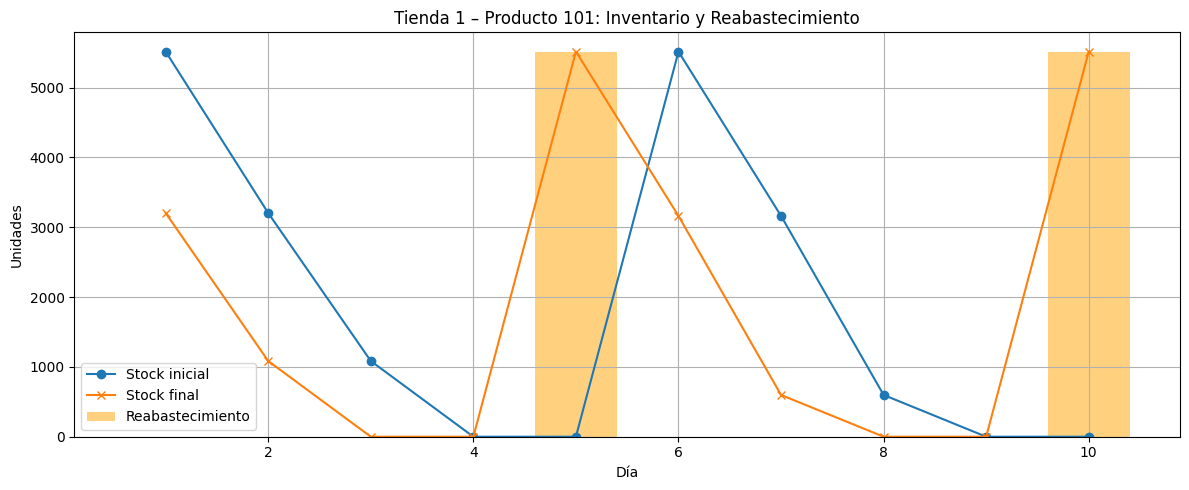

In [6]:
### Evolución de stock y reabastecimiento en el tiempo, para un solo producto en una tienda ###
# Filtrar producto y tienda que quieras analizar
tienda_id = 1
producto_id = 101
df_filtro = df_resultados[
    (df_resultados['id_tienda'] == tienda_id) &
    (df_resultados['id_producto'] == producto_id)
]

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(df_filtro['dia'], df_filtro['stock_ini'], label='Stock inicial', marker='o')
plt.plot(df_filtro['dia'], df_filtro['stock_fin'], label='Stock final', marker='x')
plt.bar(df_filtro['dia'], df_filtro['reabastece'], label='Reabastecimiento', color='orange', alpha=0.5)

plt.xlabel('Día')
plt.ylabel('Unidades')
plt.title(f'Tienda {tienda_id} – Producto {producto_id}: Inventario y Reabastecimiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


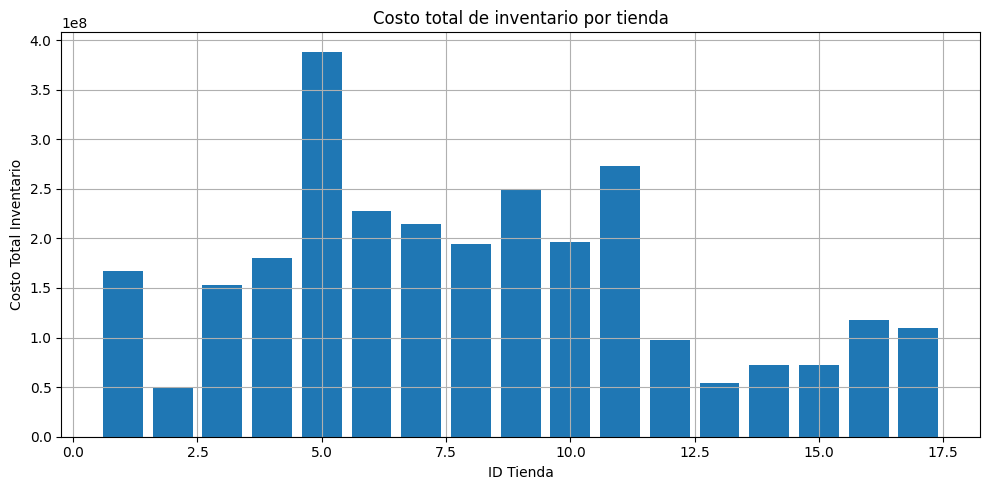

In [7]:
### Costo total de inventario por tienda ###
df_costos_por_tienda = df_resultados.groupby('id_tienda')['costo_inventario'].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(df_costos_por_tienda['id_tienda'], df_costos_por_tienda['costo_inventario'])
plt.xlabel('ID Tienda')
plt.ylabel('Costo Total Inventario')
plt.title('Costo total de inventario por tienda')
plt.grid(True)
plt.tight_layout()
plt.show()


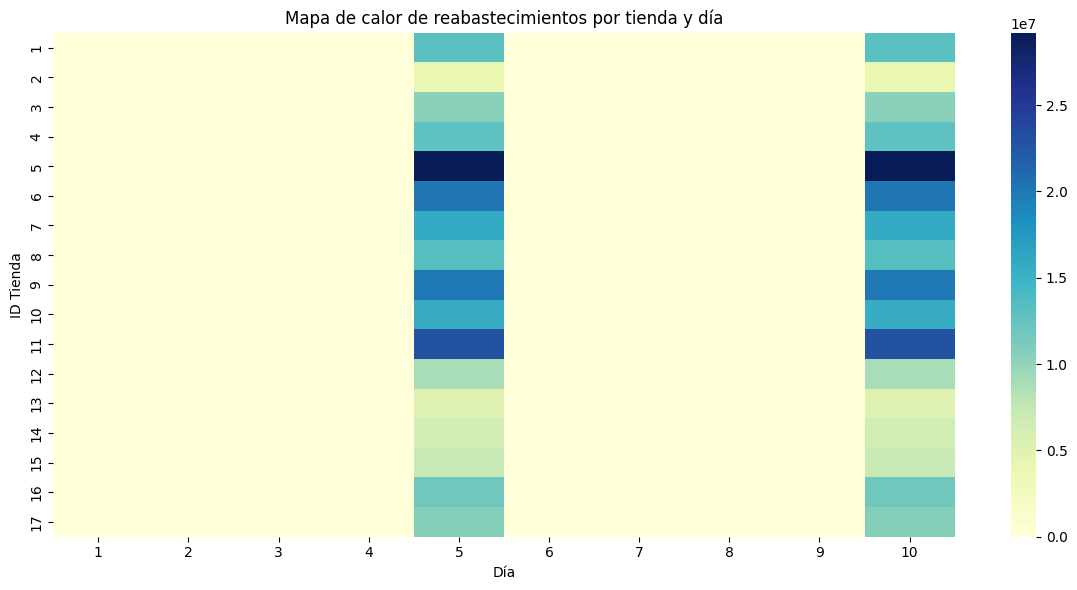

In [8]:
### Días con más reabastecimiento ###
import seaborn as sns

pivot = df_resultados.pivot_table(
    index='id_tienda', columns='dia', values='reabastece', aggfunc='sum', fill_value=0
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlGnBu', annot=False, fmt=".0f")
plt.title('Mapa de calor de reabastecimientos por tienda y día')
plt.xlabel('Día')
plt.ylabel('ID Tienda')
plt.tight_layout()
plt.show()


In [9]:
### RESUMEN POR TIENDA – Costo total de inventario ###
# Resumen por tienda
resumen_tienda = df_resultados.groupby('id_tienda').agg({
    'costo_inventario': 'sum',
    'reabastece': 'sum'
}).reset_index()

# Agregamos costo promedio diario y unidades promedio reabastecidas
resumen_tienda['costo_promedio_diario'] = resumen_tienda['costo_inventario'] / 10
resumen_tienda['reabastece_prom_dia'] = resumen_tienda['reabastece'] / 10

# Mostrar
print(resumen_tienda.sort_values('costo_inventario', ascending=False).head())


    id_tienda  costo_inventario  reabastece  costo_promedio_diario  \
4           5       388,428,905    58381570             38,842,890   
10         11       272,780,382    45804280             27,278,038   
8           9       250,332,330    40092225             25,033,233   
5           6       227,893,390    40329305             22,789,339   
6           7       214,108,201    31653969             21,410,820   

    reabastece_prom_dia  
4             5,838,157  
10            4,580,428  
8             4,009,222  
5             4,032,930  
6             3,165,397  


## 4.- Analisis de la politica base

In [10]:
# ¿Qué tiendas tienen mayores costos de inventario?
# identificamos puntos críticos donde el inventario es más costoso.
top_costos = resumen_tienda.sort_values('costo_inventario', ascending=False).head(5)
print("Tiendas con mayor costo total de inventario:")
print(top_costos)


Tiendas con mayor costo total de inventario:
    id_tienda  costo_inventario  reabastece  costo_promedio_diario  \
4           5       388,428,905    58381570             38,842,890   
10         11       272,780,382    45804280             27,278,038   
8           9       250,332,330    40092225             25,033,233   
5           6       227,893,390    40329305             22,789,339   
6           7       214,108,201    31653969             21,410,820   

    reabastece_prom_dia  
4             5,838,157  
10            4,580,428  
8             4,009,222  
5             4,032,930  
6             3,165,397  


In [11]:
# ¿Qué productos son los más reabastecidos?
# Esto muestra qué productos tienen mayor rotación o mal ajuste de 𝑄
top_productos = df_resultados.groupby('id_producto')['reabastece'].sum().reset_index()
top_productos = top_productos.sort_values('reabastece', ascending=False).head(5)
print("Productos con mayor reabastecimiento acumulado:")
print(top_productos)


Productos con mayor reabastecimiento acumulado:
     id_producto  reabastece
710          711      973840
50            51      973840
659          660      973840
253          254      952670
487          488      952670


In [12]:
# ¿Cuál es el costo total de inventario del sistema?
# valor de referencia para evaluar estrategias futuras:
costo_total_sistema = df_resultados['costo_inventario'].sum()
print(f"Costo total de inventario del sistema (10 días): ${costo_total_sistema:,.0f}")


Costo total de inventario del sistema (10 días): $2,819,959,081


## 5. Evaluación posibles políticas alternativas

### Estrategia 1: Reducir Q en un 20%
- A todos los productos y tiendas se les aplica un 80% del valor original de 𝑄
- Se mantiene la misma frecuencia de reorden que en el caso base.

In [13]:
### Estrategia 1: Reducir Q en un 20% para todos los productos ###
# Volvemos a preparar todo el entorno para comparar ambas estrategias en TODO el sistema

# Cargar archivos base necesarios
df_q = pd.read_csv(os.path.join(ruta_base, "reorden_20250115.csv"))
costo_unitario = 3.733

# ------------------- ESTRATEGIA BASE -------------------
df_ventas_base = ventas_diarias.merge(
    df_q[['id_tienda', 'id_producto', 'reorden', 'frecuencia_reorden']],
    on=['id_tienda', 'id_producto'], how='left'
).sort_values(by=['id_tienda', 'id_producto', 'dia'])

inventario_base = {}
resultados_base = []

for _, fila in df_ventas_base.iterrows():
    key = (fila['id_tienda'], fila['id_producto'])
    dia = fila['dia']
    demanda = fila['venta_total']
    Q = fila['reorden']
    frecuencia = fila['frecuencia_reorden']

    if key not in inventario_base:
        inventario_base[key] = Q

    stock_ini = inventario_base[key]
    stock_fin = max(0, stock_ini - demanda)

    reabastece = 0
    if stock_fin < Q and (dia % frecuencia == 0):
        reabastece = Q - stock_fin
        stock_fin = Q

    inventario_base[key] = stock_fin

    resultados_base.append({
        'estrategia': 'Q_base',
        'dia': dia,
        'id_tienda': fila['id_tienda'],
        'id_producto': fila['id_producto'],
        'stock_ini': stock_ini,
        'demanda': demanda,
        'reabastece': reabastece,
        'stock_fin': stock_fin,
        'costo_inventario': stock_fin * costo_unitario
    })

df_resultados_base = pd.DataFrame(resultados_base)

# ------------------- ESTRATEGIA ALTERNATIVA -------------------
df_q_alt = df_q.copy()
df_q_alt['reorden'] = (df_q_alt['reorden'] * 0.8).astype(int)

df_ventas_alt = ventas_diarias.merge(
    df_q_alt[['id_tienda', 'id_producto', 'reorden', 'frecuencia_reorden']],
    on=['id_tienda', 'id_producto'], how='left'
).sort_values(by=['id_tienda', 'id_producto', 'dia'])

inventario_alt = {}
resultados_alt = []

for _, fila in df_ventas_alt.iterrows():
    key = (fila['id_tienda'], fila['id_producto'])
    dia = fila['dia']
    demanda = fila['venta_total']
    Q = fila['reorden']
    frecuencia = fila['frecuencia_reorden']

    if key not in inventario_alt:
        inventario_alt[key] = Q

    stock_ini = inventario_alt[key]
    stock_fin = max(0, stock_ini - demanda)

    reabastece = 0
    if stock_fin < Q and (dia % frecuencia == 0):
        reabastece = Q - stock_fin
        stock_fin = Q

    inventario_alt[key] = stock_fin

    resultados_alt.append({
        'estrategia': 'Q_80_por_ciento',
        'dia': dia,
        'id_tienda': fila['id_tienda'],
        'id_producto': fila['id_producto'],
        'stock_ini': stock_ini,
        'demanda': demanda,
        'reabastece': reabastece,
        'stock_fin': stock_fin,
        'costo_inventario': stock_fin * costo_unitario
    })

df_resultados_alt = pd.DataFrame(resultados_alt)

# ------------------- COMPARACIÓN FINAL -------------------

# Unimos los resultados
df_comparacion = pd.concat([df_resultados_base, df_resultados_alt], ignore_index=True)

# KPIs por estrategia
resumen_kpi = df_comparacion.groupby('estrategia').agg({
    'costo_inventario': 'sum',
    'reabastece': 'sum'
}).reset_index()
resumen_kpi['costo_promedio_diario'] = resumen_kpi['costo_inventario'] / 10  # 10 días

print("Resumen comparativo de estrategias:")
print(resumen_kpi)



Resumen comparativo de estrategias:
        estrategia  costo_inventario  reabastece  costo_promedio_diario
0  Q_80_por_ciento     1,962,744,001   364228420            196,274,400
1           Q_base     2,819,959,081   455285216            281,995,908


In [14]:
### FUNCIÓN PARA SIMULAR POLÍTICAS ALTERNATIVAS ###
def simular_estrategia(ventas_df, q_df, etiqueta, costo_unitario=3.733):
    """
    Simula la política de inventario para una estrategia dada.

    Parámetros:
    - ventas_df: DataFrame con columnas ['dia', 'id_tienda', 'id_producto', 'venta_total']
    - q_df: DataFrame con columnas ['id_tienda', 'id_producto', 'reorden', 'frecuencia_reorden']
    - etiqueta: nombre de la estrategia (string)
    - costo_unitario: costo diario por unidad en inventario

    Retorna:
    - DataFrame con columnas: estrategia, dia, id_tienda, id_producto,
      stock_ini, demanda, reabastece, stock_fin, costo_inventario
    """
    ventas = ventas_df.merge(
        q_df[['id_tienda', 'id_producto', 'reorden', 'frecuencia_reorden']],
        on=['id_tienda', 'id_producto'], how='left'
    ).sort_values(by=['id_tienda', 'id_producto', 'dia'])

    inventario = {}
    resultados = []

    for _, fila in ventas.iterrows():
        key = (fila['id_tienda'], fila['id_producto'])
        dia = fila['dia']
        demanda = fila['venta_total']
        Q = fila['reorden']
        frecuencia = fila['frecuencia_reorden']

        if key not in inventario:
            inventario[key] = Q

        stock_ini = inventario[key]
        stock_fin = max(0, stock_ini - demanda)

        reabastece = 0
        if stock_fin < Q and (dia % frecuencia == 0):
            reabastece = Q - stock_fin
            stock_fin = Q

        inventario[key] = stock_fin

        resultados.append({
            'estrategia': etiqueta,
            'dia': dia,
            'id_tienda': fila['id_tienda'],
            'id_producto': fila['id_producto'],
            'stock_ini': stock_ini,
            'demanda': demanda,
            'reabastece': reabastece,
            'stock_fin': stock_fin,
            'costo_inventario': stock_fin * costo_unitario
        })

    return pd.DataFrame(resultados)


### Estrategia 2: Reordenar cada 3 días en lugar de cada 5

In [15]:
# Copiamos la tabla de reorden y actualizamos la frecuencia
df_q_frecuencia3 = df_q.copy()
df_q_frecuencia3['frecuencia_reorden'] = 3  # todos los productos reordenan cada 3 días

df_resultados_frec3 = simular_estrategia(ventas_diarias, df_q_frecuencia3, 'Frecuencia_3_dias')

### Estrategia 3: Q diferenciado por volumen del producto

In [16]:
# Cargamos los volúmenes de productos
df_productos = pd.read_csv(os.path.join(ruta_base, "productos_20250115.csv"))

# Clasificamos por terciles: alto, medio, bajo volumen
df_productos['vol_clase'] = pd.qcut(df_productos['volumen'], q=3, labels=['bajo', 'medio', 'alto'])

# Unimos esta clasificación al DataFrame de Q original
df_q_volumen = df_q.merge(df_productos[['id_producto', 'vol_clase']], on='id_producto', how='left')

# Aplicamos reglas de ajuste de Q según volumen
def ajustar_q(row):
    if row['vol_clase'] == 'alto':
        return int(row['reorden'] * 0.7)
    elif row['vol_clase'] == 'medio':
        return int(row['reorden'] * 0.9)
    else:  # bajo volumen
        return row['reorden']

df_q_volumen['reorden'] = df_q_volumen.apply(ajustar_q, axis=1)

# Simular estrategia por volumen
df_resultados_volumen = simular_estrategia(ventas_diarias, df_q_volumen, 'Q_diferenciado_volumen')

In [17]:
### RESULTADOS Y COMPARATIVA DE LOS KPIs ###
# Unimos todos los resultados
df_comparacion_todas = pd.concat([
    df_resultados_base,
    df_resultados_alt,
    df_resultados_frec3,
    df_resultados_volumen
], ignore_index=True)

# Recalculamos KPIs por estrategia
resumen_kpis = df_comparacion_todas.groupby('estrategia').agg({
    'costo_inventario': 'sum',
    'reabastece': 'sum'
}).reset_index()
resumen_kpis['costo_promedio_diario'] = resumen_kpis['costo_inventario'] / 10

resumen_kpis

,estrategia,costo_inventario,reabastece,costo_promedio_diario
0,Frecuencia_3_dias,"4,548,977,126",682328008,"454,897,713"
1,Q_80_por_ciento,"1,962,744,001",364228420,"196,274,400"
2,Q_base,"2,819,959,081",455285216,"281,995,908"
3,Q_diferenciado_volumen,"2,260,911,310",394348220,"226,091,131"


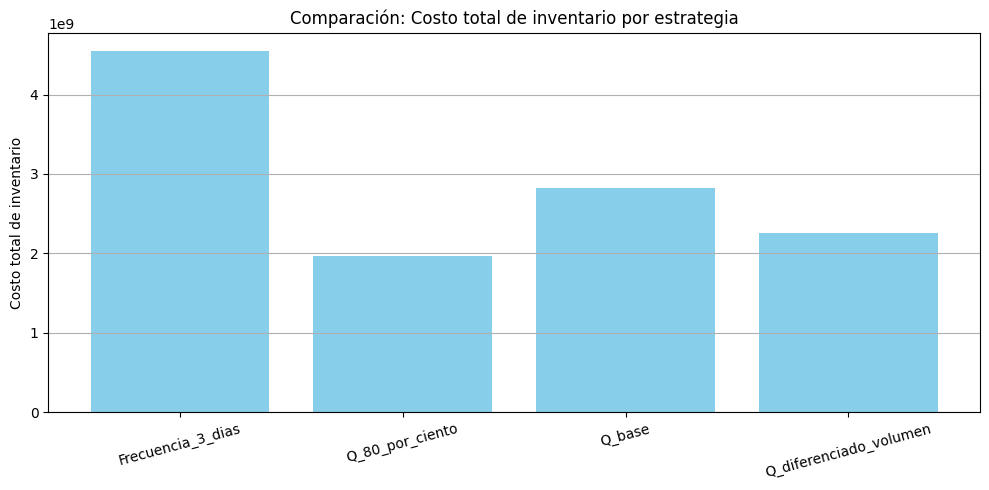

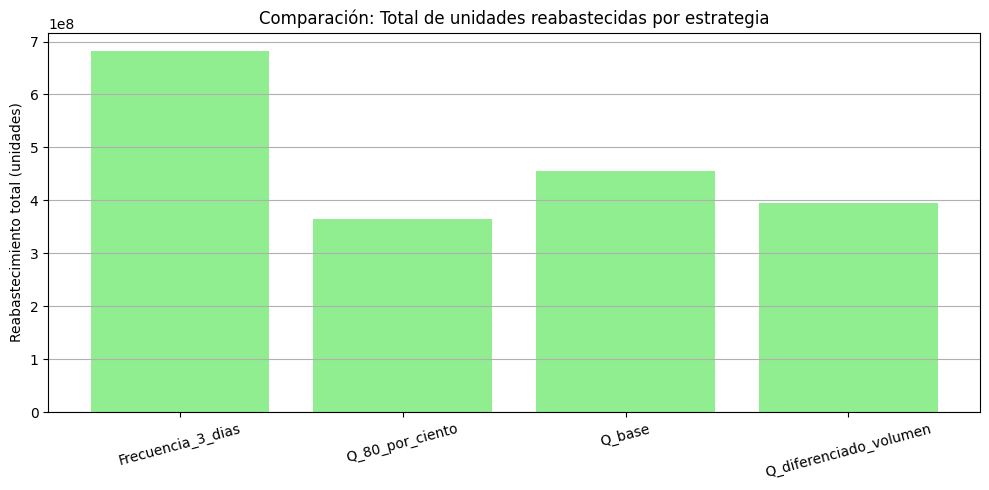

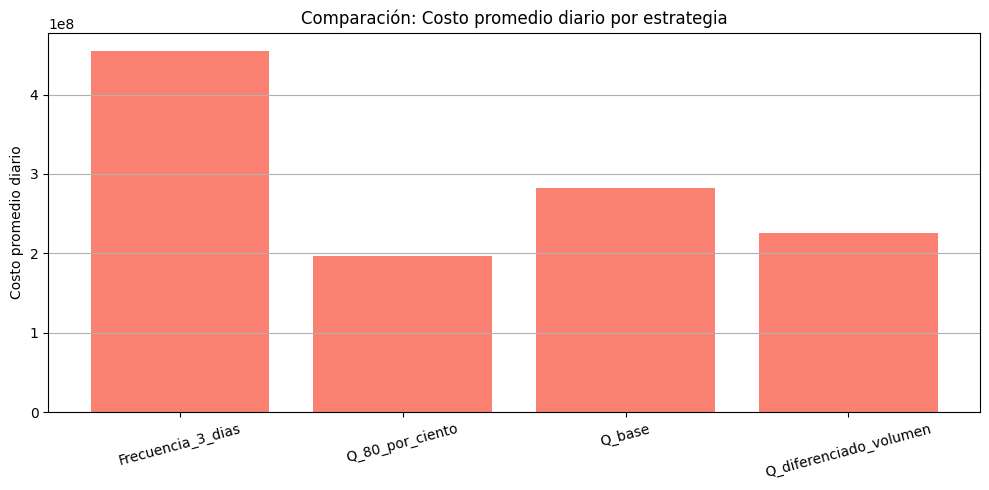

In [19]:
import matplotlib.pyplot as plt

# Gráfico 1: Costo total de inventario
plt.figure(figsize=(10, 5))
plt.bar(resumen_kpis['estrategia'], resumen_kpis['costo_inventario'], color='skyblue')
plt.ylabel('Costo total de inventario')
plt.title('Comparación: Costo total de inventario por estrategia')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Gráfico 2: Reabastecimiento total
plt.figure(figsize=(10, 5))
plt.bar(resumen_kpis['estrategia'], resumen_kpis['reabastece'], color='lightgreen')
plt.ylabel('Reabastecimiento total (unidades)')
plt.title('Comparación: Total de unidades reabastecidas por estrategia')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Gráfico 3: Costo promedio diario
plt.figure(figsize=(10, 5))
plt.bar(resumen_kpis['estrategia'], resumen_kpis['costo_promedio_diario'], color='salmon')
plt.ylabel('Costo promedio diario')
plt.title('Comparación: Costo promedio diario por estrategia')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Simulación 2
Incorporo:
- quiebre: si el inventario inicial no alcanza para cubrir la demanda.
- unidades_insatisfechas: la diferencia entre demanda y entrega real.
- entrega: lo efectivamente entregado (lo mínimo entre stock inicial y demanda).

In [21]:
#Añado quiebres de stock, unidades insatisfechas y entregas a la simulación:
# Reimportamos todo después del reinicio del entorno
import pandas as pd

# Redefinimos la función con detección de quiebre de stock
def simular_estrategia(ventas_df, q_df, etiqueta, costo_unitario=3.733):
    ventas = ventas_df.merge(
        q_df[['id_tienda', 'id_producto', 'reorden', 'frecuencia_reorden']],
        on=['id_tienda', 'id_producto'], how='left'
    ).sort_values(by=['id_tienda', 'id_producto', 'dia'])

    inventario = {}
    resultados = []

    for _, fila in ventas.iterrows():
        key = (fila['id_tienda'], fila['id_producto'])
        dia = fila['dia']
        demanda = fila['venta_total']
        Q = fila['reorden']
        frecuencia = fila['frecuencia_reorden']

        if key not in inventario:
            inventario[key] = Q

        stock_ini = inventario[key]
        entrega = min(stock_ini, demanda)
        quiebre = int(stock_ini < demanda)
        unidades_insatisfechas = max(0, demanda - stock_ini)

        stock_fin = stock_ini - entrega
        reabastece = 0

        if stock_fin < Q and (dia % frecuencia == 0):
            reabastece = Q - stock_fin
            stock_fin = Q

        inventario[key] = stock_fin

        resultados.append({
            'estrategia': etiqueta,
            'dia': dia,
            'id_tienda': fila['id_tienda'],
            'id_producto': fila['id_producto'],
            'stock_ini': stock_ini,
            'demanda': demanda,
            'entrega': entrega,
            'unidades_insatisfechas': unidades_insatisfechas,
            'quiebre': quiebre,
            'reabastece': reabastece,
            'stock_fin': stock_fin,
            'costo_inventario': stock_fin * costo_unitario
        })

    return pd.DataFrame(resultados)
